In [1]:
import numpy as np
import pandas as pd

import scipy

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Домашняя работа»</b></h3>


In [4]:
data_path = "https://raw.githubusercontent.com/a-milenkin/mipt_data_science_2021/main/data/people_data_clustering.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head()

Размеры датасета (6000, 9)


,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `children` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол (0 - женщина, 1 - мужчина)
* `age` - Возраст
* `home_cost` - Сумарная стоимость жилья/недвижимости
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
* `happyness` - уровень счастья по результатам опроса
    
</div>

<div class="alert alert-info">
<b>Задание</b>

Изучить датасет, выполнить задания и проверить некоторые гипотезы, предложенные ниже, используя только визуализацию.

# Изучение датасета 
* Какие признаки численные?
* Какие признаки категориальные?
* Какие признаки имеют нормальное распределение?
* Какие признаки бессмысленные?

Численные признаки:  ['was_married', 'children', 'salary', 'sex', 'age', 'home_cost', 'drive_info', 'happyness']
Категориальные признаки:  ['profession']


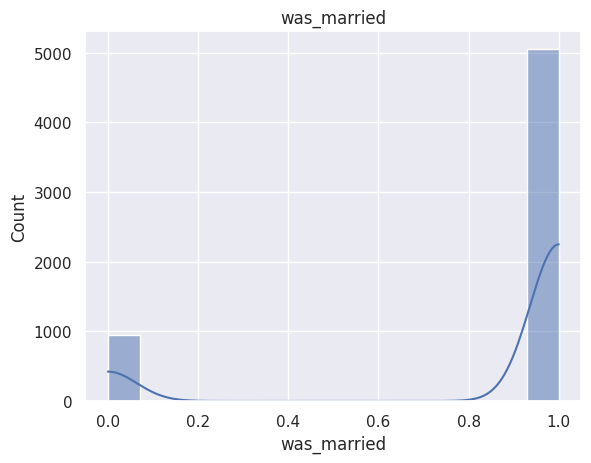

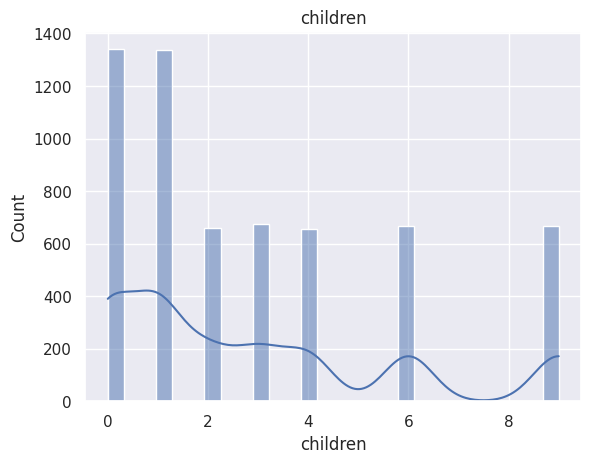

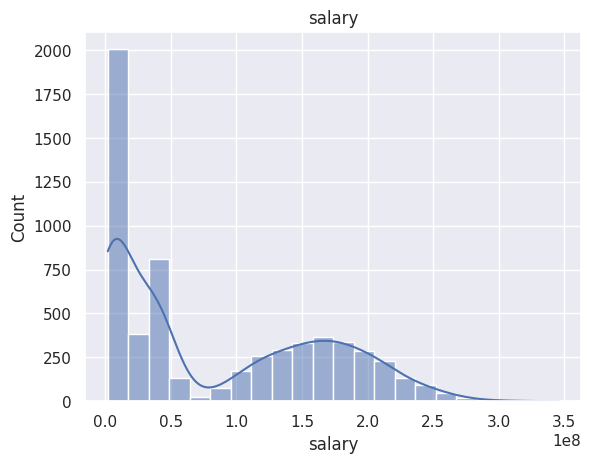

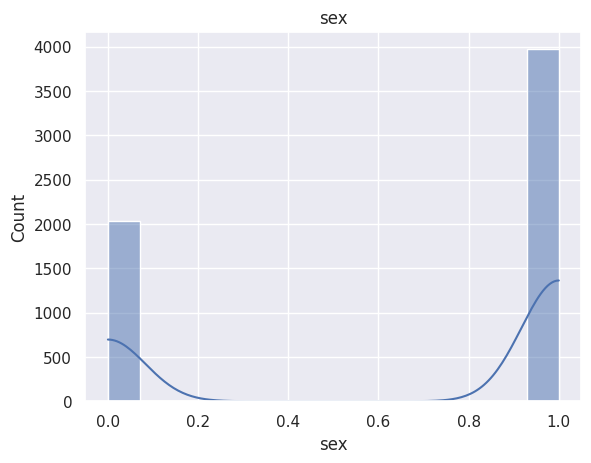

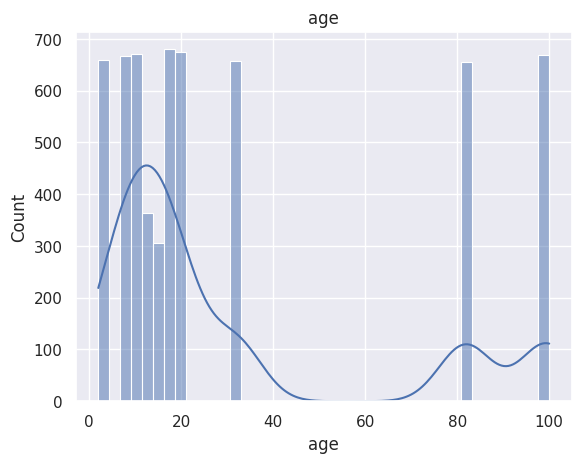

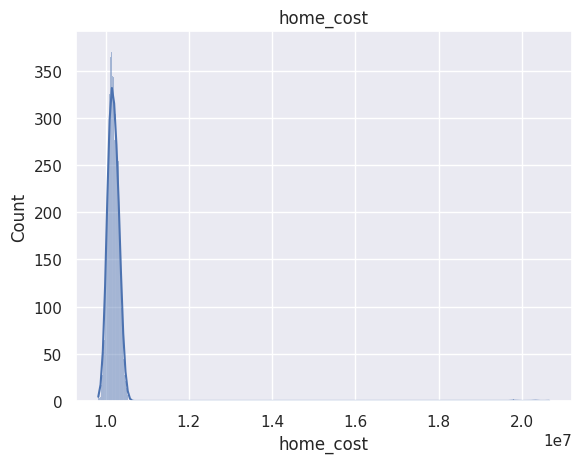

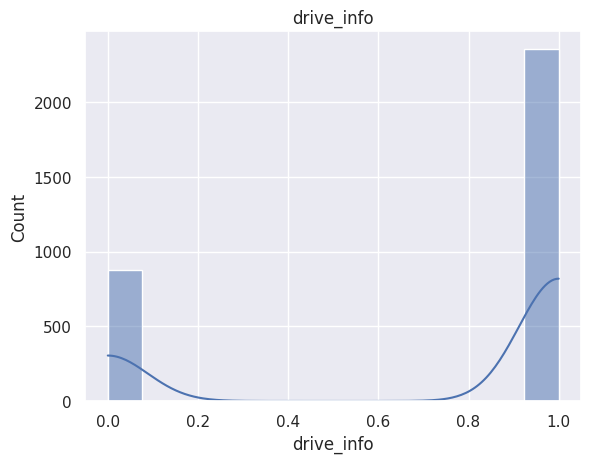

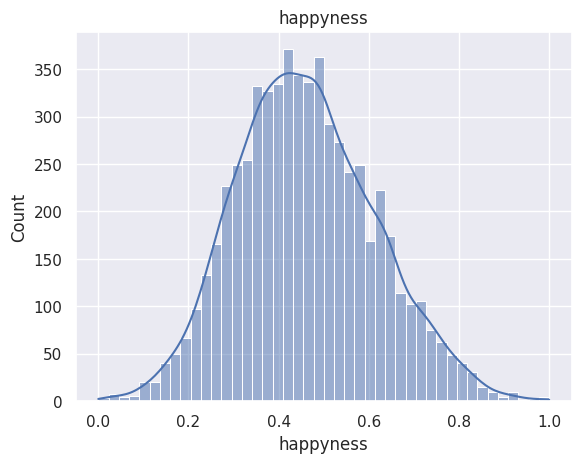

Feature was_married: 0 missing values, 2 unique values
Feature children: 0 missing values, 7 unique values
Feature salary: 0 missing values, 6000 unique values
Feature sex: 0 missing values, 2 unique values
Feature age: 0 missing values, 20 unique values
Feature profession: 0 missing values, 9 unique values
Feature home_cost: 0 missing values, 5500 unique values
Feature drive_info: 2770 missing values, 2 unique values
Feature happyness: 0 missing values, 6000 unique values


In [11]:
# Какие признаки численные?
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
print("Численные признаки: ", numerical_features)

# Какие признаки категориальные?
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
print("Категориальные признаки: ", categorical_features)

# Какие признаки имеют нормальное распределение?
for feature in numerical_features:
    sns.histplot(data[feature], kde=True)
    plt.title(feature)
    plt.show()

# Какие признаки бессмысленные?
# Бессмысленными могут быть признаки, которые одинаковы для всех объектов, или признаки, в которых большинство значений пропущено.
for feature in data.columns:
    print(f"Feature {feature}: {data[feature].isna().sum()} missing values, {data[feature].nunique()} unique values")

# Чистка датасета
* Есть ли дубли в данных? Если есть - удалить их (`drop_duplicates`). 
* Есть ли пропуски в данных? Если есть - удалить столбцы, в которых они есть. (`dropna()`)
* Найти и удалить выбросы по признаку `home_cost`. Сколько их?

In [14]:
# Проверка на дубликаты
print("Дубликаты до удаления: ", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Дубликаты после удаления: ", data.duplicated().sum())

# Проверка на пропуски в данных
print("Пропуски до удаления: \n", data.isnull().sum())
data.dropna(axis=1, inplace=True)
print("Пропуски после удаления: \n", data.isnull().sum())

# Поиск и удаление выбросов по признаку 'home_cost'
Q1 = data['home_cost'].quantile(0.25)
Q3 = data['home_cost'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((data['home_cost'] < (Q1 - 1.5 * IQR)) | (data['home_cost'] > (Q3 + 1.5 * IQR)))
print("Количество выбросов до удаления: ", outliers.sum())
data = data[~outliers]
print("Количество выбросов после удаления: ",
      ((data['home_cost'] < (Q1 - 1.5 * IQR)) | (data['home_cost'] > (Q3 + 1.5 * IQR))).sum())

Дубликаты до удаления:  0
Дубликаты после удаления:  0
Пропуски до удаления: 
 was_married       0
children          0
salary            0
sex               0
age               0
profession        0
home_cost         0
drive_info     2770
happyness         0
dtype: int64
Пропуски после удаления: 
 was_married    0
children       0
salary         0
sex            0
age            0
profession     0
home_cost      0
happyness      0
dtype: int64
Количество выбросов до удаления:  13
Количество выбросов после удаления:  0


# Проверка гипотез

Проверьте следующие гипотезы. Для доказательства - используйте визуализацию. (Статистические методы использовать не нужно)

<div class="alert alert-warning">
    
* Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?
нет

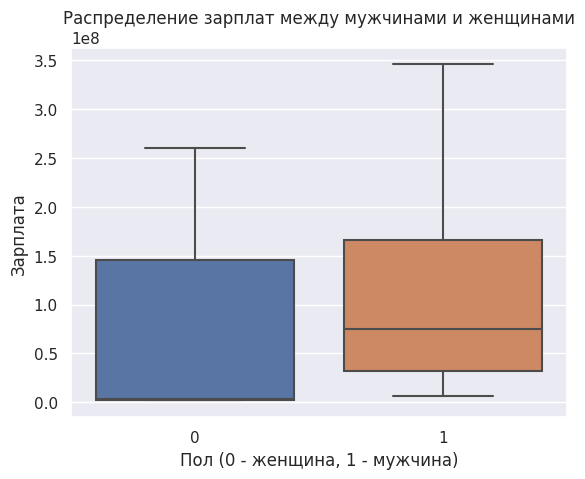

In [15]:
sns.boxplot(x='sex', y='salary', data=data)
plt.title('Распределение зарплат между мужчинами и женщинами')
plt.xlabel('Пол (0 - женщина, 1 - мужчина)')
plt.ylabel('Зарплата')
plt.show()

<div class="alert alert-warning">
    
* Правда ли, что инженеры (Engineer) зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?
нет

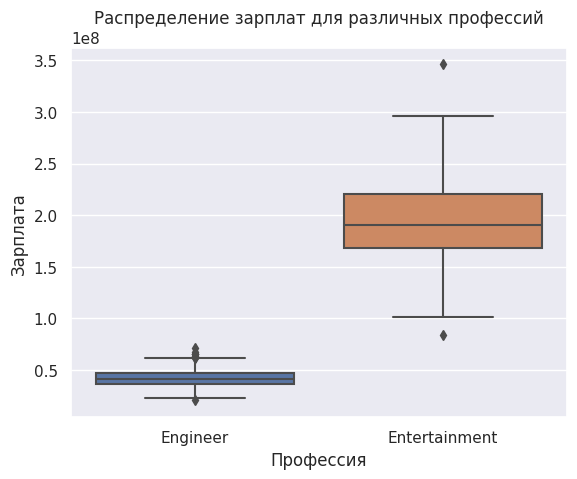

In [16]:
subset = data[data['profession'].isin(['Engineer', 'Entertainment'])]

sns.boxplot(x='profession', y='salary', data=subset)
plt.title('Распределение зарплат для различных профессий')
plt.xlabel('Профессия')
plt.ylabel('Зарплата')
plt.show()

<div class="alert alert-warning">
    
* Правда ли, что те, у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей?
да

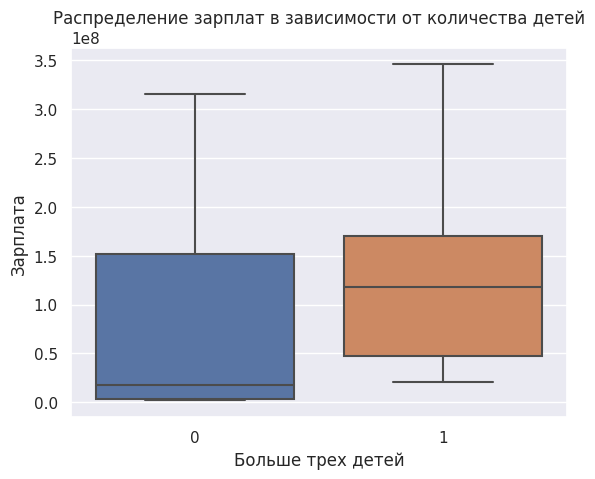

In [24]:
data.loc[data['children'] > 3, 'more_than_three_children'] = 1
data.loc[data['children'] <= 3, 'more_than_three_children'] = 0

sns.boxplot(x='more_than_three_children', y='salary', data=data)
plt.title('Распределение зарплат в зависимости от количества детей')
plt.xlabel('Больше трех детей')
plt.ylabel('Зарплата')
plt.show()

<div class="alert alert-warning">
    
* Правда ли, что дома художники (Artist) живут в домах, которые в среднем дороже или дешевле, чем дома адвокатов (Lawyer)?
нет

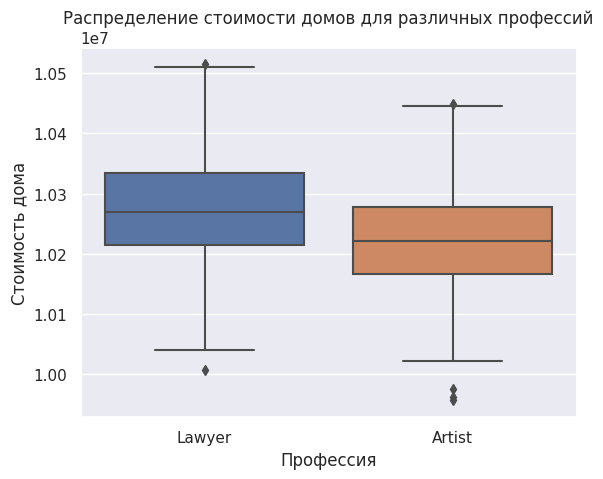

In [19]:
subset = data[data['profession'].isin(['Artist', 'Lawyer'])]

sns.boxplot(x='profession', y='home_cost', data=subset)
plt.title('Распределение стоимости домов для различных профессий')
plt.xlabel('Профессия')
plt.ylabel('Стоимость дома')
plt.show()

<div class="alert alert-warning">
    
* Правда ли, что недвижимость у тех, кто когда либо был в браке в среднем дороже, чем у тех, кто никогда не был в браке?
нет


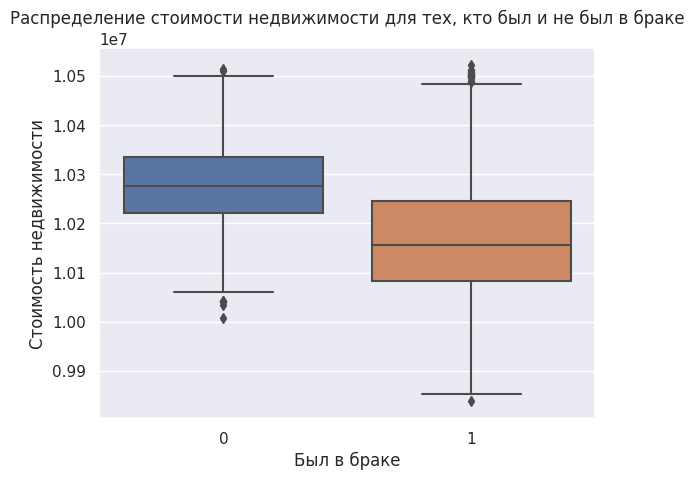

In [20]:
sns.boxplot(x='was_married', y='home_cost', data=data)
plt.title('Распределение стоимости недвижимости для тех, кто был и не был в браке')
plt.xlabel('Был в браке')
plt.ylabel('Стоимость недвижимости')
plt.show()

<div class="alert alert-warning">
    
* Правда ли, что мужчины в среднем чаще бывают в браке, чем женщины?
да

**Подсказка** - составьте матрицу смежности, она выглядит примерно вот так:


In [6]:
# ******  был в браке | не был в браке |
# мужчины      140    |      499       |
# женщины      241    |      298       |

In [22]:
pivot_table = data.pivot_table(index='sex', columns='was_married', aggfunc='size')

# переименование индексов и столбцов для наглядности
pivot_table.index = ['Женщины', 'Мужчины']
pivot_table.columns = ['Не был в браке', 'Был в браке']

print(pivot_table)


         Не был в браке  Был в браке
Женщины             668         1355
Мужчины             277         3687
